In [ ]:
 !pip install optuna

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [17]:
# Load
df = pd.read_csv("/content/energy_iter13b.csv")

In [ ]:
target_column = "Demand(MW)"

X = df.drop(columns=['Demand(MW)','Date','DemandGenGap(MW)']).values  # Features
y = df['Demand(MW)'].values  # Target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()

        
        model_dim = (model_dim // num_heads) * num_heads

        self.input_layer = nn.Linear(input_dim, model_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.transformer_encoder(x)
        x = self.output_layer(x)
        return x

#Define Objective Function for Hyperparameter Tuning
def objective(trial):

    # Define hyperparameter 
    num_heads = trial.suggest_categorical("num_heads", [2, 4, 8, 16])
    model_dim = trial.suggest_int("model_dim", 32, 256, step=num_heads)  # Ensure divisibility
    num_layers = trial.suggest_int("num_layers", 2, 6)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    # Initialize model
    model = TransformerModel(
        input_dim=X.shape[1], model_dim=model_dim, num_heads=num_heads,
        num_layers=num_layers, dropout=dropout
    )

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).numpy().flatten()

    r2 = r2_score(y_test, predictions)
    return r2  # for maximize R² score

# Hyperparameter Tuning
study = optuna.create_study(direction="maximize")  # Maximize R²
study.optimize(objective, n_trials=50)  # Run 50 trials

# Get best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train final model with best parameters
best_model = TransformerModel(
    input_dim=X.shape[1], model_dim=best_params["model_dim"],
    num_heads=best_params["num_heads"], num_layers=best_params["num_layers"],
    dropout=best_params["dropout"]
)

optimizer = optim.Adam(best_model.parameters(), lr=best_params["learning_rate"])
criterion = nn.MSELoss()

# Train Final Model
for epoch in range(50):
    best_model.train()
    optimizer.zero_grad()
    predictions = best_model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluate Final Model
best_model.eval()
with torch.no_grad():
    final_predictions = best_model(X_test_tensor).numpy().flatten()

final_r2 = r2_score(y_test, final_predictions)
print(f"Final Model R² Score: {final_r2:.4f}")

[I 2025-03-21 08:24:25,085] A new study created in memory with name: no-name-aeddd580-8630-41c2-bfea-7d548e16b0e8
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-03-21 08:29:34,876] Trial 0 finished with value: 0.4737012420224529 and parameters: {'num_heads': 16, 'model_dim': 144, 'num_layers': 5, 'dropout': 0.4173761965677685, 'learning_rate': 0.00020839316246180084}. Best is trial 0 with value: 0.4737012420224529.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2025-03-21 08:35:00,068] Trial 1 finished with value: 0.7

Best Hyperparameters: {'num_heads': 4, 'model_dim': 52, 'num_layers': 2, 'dropout': 0.12443879663815581, 'learning_rate': 0.00017976216190681053}
Final Model R² Score: 0.8700


Final Model R² Score: 0.8700
Mean Absolute Error (MAE): 0.0529
Root Mean Squared Error (RMSE): 0.0734


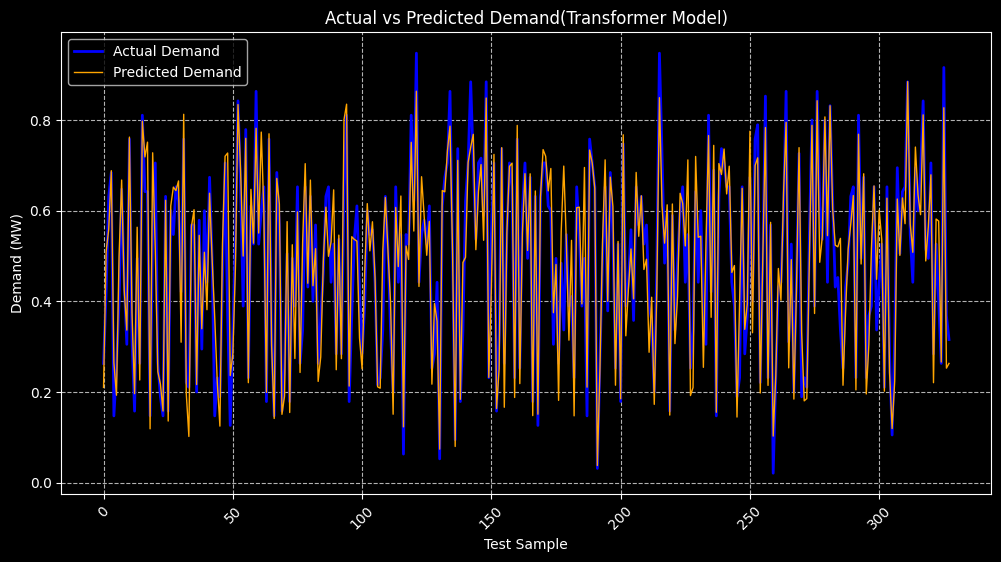

In [ ]:
# Calculate evaluation 
final_r2 = r2_score(y_test, final_predictions)
mae = mean_absolute_error(y_test, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print(f"Final Model R² Score: {final_r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.makedirs("./generated", exist_ok=True)


plt.figure(figsize=(12, 6))
sns.set_palette(palette='gnuplot2_r')
plt.style.use('dark_background')
plt.plot(y_test, label="Actual Demand", color='blue', linewidth=2)
plt.plot(final_predictions, label="Predicted Demand", color='orange', linestyle='solid',linewidth=1)
plt.xlabel("Test Sample")
plt.ylabel("Demand (MW)")
plt.title("Actual vs Predicted Demand(Transformer Model)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('./generated/transformer1.1.png',dpi=500)
plt.show()
